# Link sparsification Figure 4 (b) and (c)

Latest update (Sep. 3, 2025): 
- update pandas DataFrame operations for python3.10
- adjust fonts in `matplotlib` and `seaborn` for IEEE TWC final version (Accepted fonts: Symbol, Helvetica, Arial, Time New Roman)

In [4]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from test_utils import *

In [5]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    "ps.fonttype": 42,      # embed TrueType in EPS
    "pdf.fonttype": 42,
    "savefig.transparent": False,  # no page transparency (EPS can't do alpha)
    "legend.framealpha": 1.0,      # if you use legends, make them opaque
})

In [6]:
def graph_degree(fullpath):
    mat_contents = sio.loadmat(fullpath)
    adj_gK = mat_contents['adj']
    wts = mat_contents['weights'].transpose()
    nflows = adj_gK.shape[0]
    graph_i = nx.from_scipy_sparse_array(adj_gK)

    d_list = []
    for v in graph_i:
        d_list.append(graph_i.degree[v])
    degrees = np.asarray(d_list)
    return degrees

def convertDf(df):
    df1 = df.rename(columns={"file": 'data', "ratio": 'p'})
    return df1.set_index('data')


## Fig. 4(c): Analysis of normalized utility vs cutoff quantile

In [7]:
graphtype = 'BA'
dataset = '{}_Graph_Uniform_GEN24_test2'.format(graphtype)
benchmarks = {
    'deadline': 'relative_utility_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_deadline_BA_Graph_Uniform_GEN24_test2_SPADL1.csv',
    'overhead': 'relative_utility_1-channel_utility-qr_opt-0_graph-ertest_load-0.08_layer-1_level-all_sparsify_overhead_BA_Graph_Uniform_GEN24_test2_SPAOH1.csv',
    'qcsma': 'relative_utility_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_qcsma_BA_Graph_Uniform_GEN24_test2_W-32_SPAQC1.csv',
    'csma': 'relative_utility_1-channel_utility-qr_opt-0_graph-ertest_load-0.03_layer-1_level-all_sparsify_csma_BA_Graph_Uniform_GEN24_test2_W-32_SPAQC1.csv',
}
output_dir = './wireless'
experiments = benchmarks.keys()

In [10]:
df = pd.DataFrame()
for experiment in experiments:
    filepath=os.path.join(output_dir, benchmarks[experiment])
    df_tmp = pd.read_csv(filepath, index_col=False)
    df_tmp = extract_df_info(df_tmp)
    df_tmp=df_tmp[df_tmp['name']=='single']
    df_tmp['exp']=experiment
    df = pd.concat([df, df_tmp], ignore_index=True)
df.drop(columns=['avg_queue_len','50p_queue_len','95p_queue_len','avg_throughput','runtime'], inplace=True)
df

,graph,seed,load,name,level,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,N_p,N,exp
0,BA_n100_p0.02_b0_uni.mat,190140919,0.06,single,0.21,0.800,0.673469,3.299996,3,286,148,0.975260,3.92,2.0,100,deadline
1,BA_n100_p0.02_b0_uni.mat,190140919,0.06,single,0.94,0.060,0.005102,0.333328,1,2,11,0.183606,3.92,2.0,100,deadline
2,BA_n100_p0.02_b0_uni.mat,190140919,0.06,single,0.97,0.050,0.000000,0.000000,1,0,10,0.191565,3.92,2.0,100,deadline
3,BA_n100_p0.02_b0_uni.mat,190140919,0.06,single,0.10,0.930,0.872449,3.677415,3,366,177,0.993533,3.92,2.0,100,deadline
4,BA_n100_p0.02_b0_uni.mat,190140919,0.06,single,0.76,0.300,0.076531,0.999997,2,32,55,0.683792,3.92,2.0,100,deadline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34395,BA_n500_p0.1_b9_uni.mat,1110478182,0.06,single,0.34,0.650,0.399600,27.664607,0,0,5,3.279575,90.00,50.0,500,csma
34396,BA_n500_p0.1_b9_uni.mat,1110478182,0.06,single,0.20,0.810,0.676089,37.560485,0,0,4,1.018273,90.00,50.0,500,csma
34397,BA_n500_p0.1_b9_uni.mat,1110478182,0.06,single,0.10,0.886,0.786356,39.939043,0,0,1,1.591380,90.00,50.0,500,csma
34398,BA_n500_p0.1_b9_uni.mat,1110478182,0.06,single,0.97,0.042,0.002533,2.714273,0,0,5,4.847051,90.00,50.0,500,csma


(0.0, 10.0)

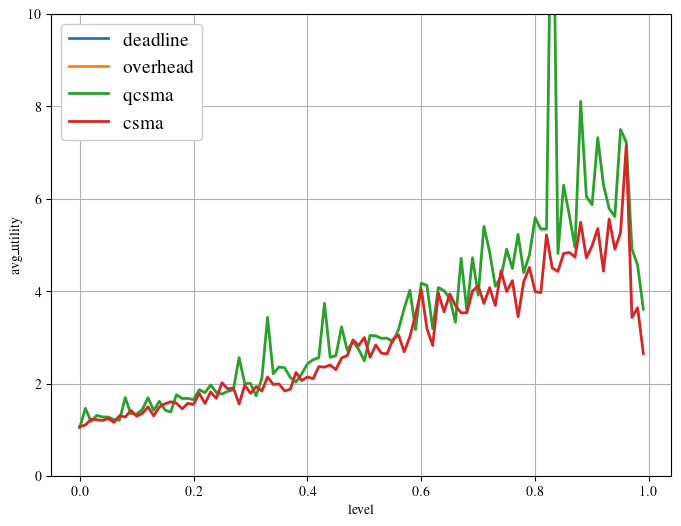

In [11]:
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(8, 6))
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)
data=df[df['exp'].isin(['qcsma','csma'])]
data=data[data['N_p']>20]
data=data[data['avg_utility']>0]
data=data[data['avg_utility']<np.inf]
sns.lineplot(
    x="level", y="avg_utility", hue="exp", 
#     data=df[df['exp']!='qcsma'], 
    data=data, 
    hue_order=experiments,
    ci=True,
    linewidth=2.0, 
    palette="tab10", 
    markers=True,
    markersize=16,
    ax=ax,
)
L = ax.legend(fontsize=14)
ax.grid(True)
ax.set_ylim([0,10])

In [355]:
data[data['level']==0.30]

,graph,seed,load,name,level,avg_n_ratio,avg_e_ratio,avg_deg_sp,avg_s_ratio,avg_p2p_ratio,avg_bst_ratio,avg_utility,avg_degree,N_p,N,exp
22293,BA_n300_p0.083_b18_uni.mat,1044244580,0.05,single,0.3,0.703333,0.500364,16.303310,0,0,7,166.562669,45.833333,25.0,300,qcsma
22560,BA_n300_p0.1_b6_uni.mat,3123468313,0.06,single,0.3,0.680000,0.457284,18.156854,0,0,3,2.716792,54.000000,30.0,300,qcsma
22832,BA_n300_p0.133_b12_uni.mat,814193403,0.04,single,0.3,0.673333,0.448077,23.069296,0,0,1,0.629140,69.333333,40.0,300,qcsma
23122,BA_n300_p0.15_b2_uni.mat,3332099413,0.05,single,0.3,0.636667,0.394161,23.680616,0,0,1,0.519448,76.500000,45.0,300,qcsma
23503,BA_n400_p0.062_b19_uni.mat,4281660710,0.06,single,0.3,0.660000,0.428693,15.223479,0,0,7,25.419858,46.875000,25.0,400,qcsma
23577,BA_n400_p0.062_b7_uni.mat,3222883051,0.06,single,0.3,0.697500,0.494080,16.602145,0,0,4,0.792178,46.875000,25.0,400,qcsma
23596,BA_n400_p0.062_b9_uni.mat,3165664722,0.06,single,0.3,0.687500,0.469973,16.021812,0,0,5,1.728631,46.875000,25.0,400,qcsma
23654,BA_n400_p0.075_b14_uni.mat,2703460969,0.04,single,0.3,0.710000,0.510270,19.943655,0,0,4,0.831221,55.500000,30.0,400,qcsma
23777,BA_n400_p0.075_b7_uni.mat,2614783459,0.04,single,0.3,0.690000,0.447658,18.003617,0,0,3,1.433268,55.500000,30.0,400,qcsma
23789,BA_n400_p0.075_b8_uni.mat,239977904,0.05,single,0.3,0.690000,0.461351,18.554341,0,0,4,1.277344,55.500000,30.0,400,qcsma


In [12]:
# data = df[df['exp'].isin(['qcsma','csma'])]
data = df[df['exp'].isin(['deadline', 'overhead'])]
u_by_eta = data.groupby(by='level', axis=0)['avg_utility'].mean()
u_by_eta

level
0.00    1.000000
0.01    0.999976
0.02    0.999916
0.03    0.999746
0.04    0.999607
          ...   
0.95    0.289292
0.96    0.235180
0.97    0.202997
0.98    0.154958
0.99    0.095893
Name: avg_utility, Length: 100, dtype: float64

In [14]:
# find degree distribution of graphs
# 1. get all the graphs of Np=50
target_graphs = df[df['N_p']>=20]
target_graphs = target_graphs['graph'].unique().tolist()
n_degs=np.array([])
for graph in target_graphs:
    mat_contents = sio.loadmat(os.path.join('./data/{}'.format(dataset), graph))
    adj_gK = mat_contents['adj']
    degs=adj_gK.sum(1)
    n_degs = np.concatenate((n_degs.flatten(), np.array(degs).flatten()))    
    
n_degs

FileNotFoundError: [Errno 2] No such file or directory: './data/BA_Graph_Uniform_GEN24_test2/BA_n100_p0.2_b0_uni.mat'

In [330]:
np.savetxt('./data/node_degree_BA_Uniform_GEN24_test2.csv', n_degs, delimiter=',')

In [15]:
n_degs = np.loadtxt('./data/node_degree_BA_Uniform_GEN24_test2.csv', delimiter=',')

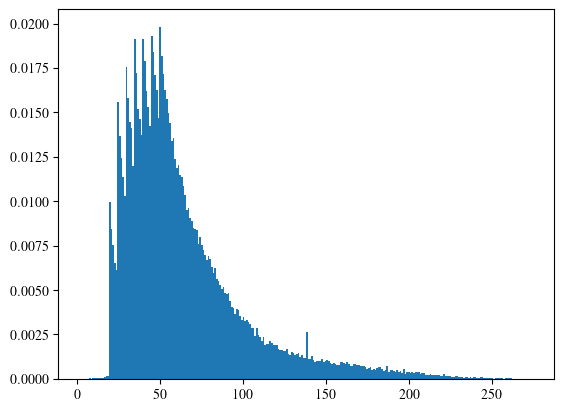

In [16]:
num_unique = len(np.unique(n_degs))
bin_edges = np.arange(n_degs.min(), n_degs.max() + 1.0, 1.0)

# create a histogram with the number of bins set to the number of unique values
hist, bins = np.histogram(n_degs, bins=num_unique, density=True)

# plot the histogram
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')
plt.show()

In [17]:
np.dot(hist, bins[:-1])

62.68007460545195

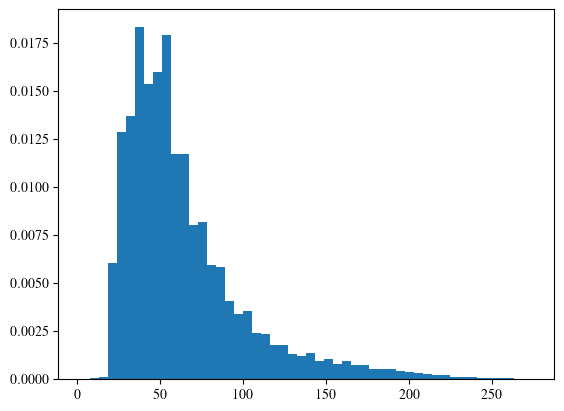

In [18]:
# create a histogram with the number of bins set to the number of unique values
hist2, bins2 = np.histogram(n_degs, bins=50, density=True)

# plot the histogram
plt.bar(bins2[:-1], hist2, width=np.diff(bins2), align='edge')
plt.show()

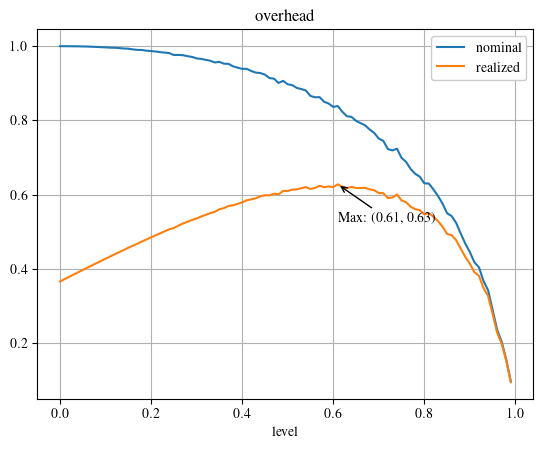

In [19]:
experiment = 'overhead'
tau=0.01
degs = bins[:-1]
def r_realize(hist, degs, levels):
    realized = []
    for level in levels:
        rx = 1.0 - tau*degs * (1.0-level)
        rx_mean = np.dot(hist, rx)
        realized.append(rx_mean)
    return np.array(realized).flatten()
levels = u_by_eta.index.to_numpy()
Np=62.68
r_est = r_realize(hist, degs, levels)
u_est = pd.DataFrame([], columns=['nominal','realized'], index=u_by_eta.index)
u_est['nominal'] = u_by_eta
u_est['realized'] = u_est['nominal'].multiply(r_est, axis=0)
ax = u_est.plot(y=['nominal','realized'])

max_index = u_est['realized'].idxmax()
x = max_index
y = u_est.loc[max_index, 'realized']
ax.annotate(f"Max: ({x}, {y:.2f})", xy=(x, y), xytext=(x, y-0.1), arrowprops=dict(facecolor='red', arrowstyle="->"))
ax.set_title(experiment)
ax.grid(True)
u_est_all=u_est.copy()
u_est_all.rename(columns={'realized':'overhead'}, inplace=True)

0.69 level
0.00    0.120377
0.01    0.136207
0.02    0.136199
0.03    0.136176
0.04    0.150635
          ...   
0.95    0.287165
0.96    0.233451
0.97    0.201504
0.98    0.153819
0.99    0.095187
Name: realized, Length: 100, dtype: float64


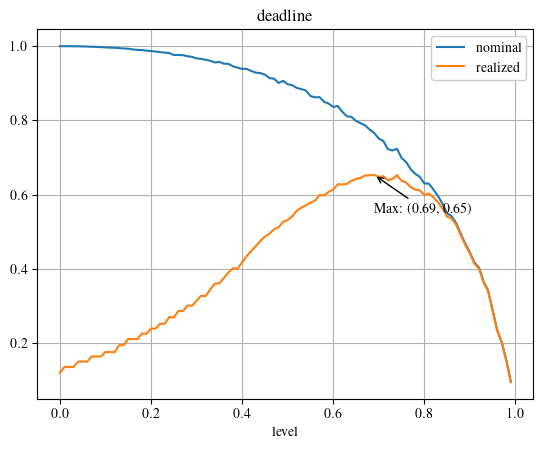

In [20]:
experiment = 'deadline'
tau=0.01
degs = bins[:-1]
def r_realize(hist, degs, levels):
    realized = []
    for level in levels:
        oh = tau*degs * (1.0-level)
        rx = np.zeros_like(oh)
        rx[oh <= 0.3] = 1.0
        rx_mean = np.dot(hist, rx)
        realized.append(rx_mean)
    return np.array(realized).flatten()
levels = u_by_eta.index.to_numpy()
r_est = r_realize(hist, degs, levels)
u_est = pd.DataFrame([], columns=['nominal','realized'], index=u_by_eta.index)
u_est['nominal'] = u_by_eta
u_est['realized'] = u_est['nominal'].multiply(r_est, axis=0)
ax = u_est.plot(y=['nominal','realized'])

max_index = u_est['realized'].idxmax()
x = max_index
y = u_est.loc[max_index, 'realized']
ax.annotate(f"Max: ({x}, {y:.2f})", xy=(x, y), xytext=(x, y-0.1), arrowprops=dict(facecolor='red', arrowstyle="->"))
ax.set_title(experiment)
ax.grid(True)
print(max_index, u_est['realized'])
u_est_all['deadline'] = u_est['realized']

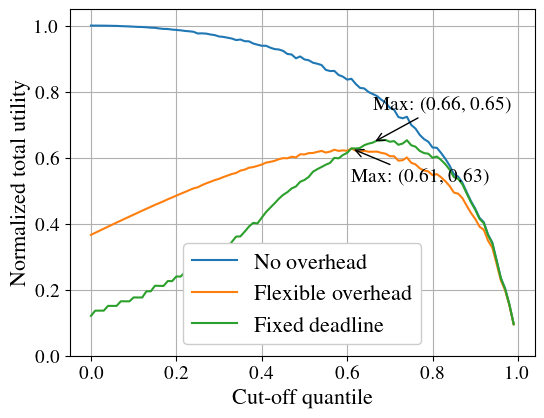

In [21]:
fig, ax = plt.subplots()
u_est_all.plot(y=['nominal','overhead','deadline'], ax=ax)
ax.grid(True)
max_index = u_est_all['overhead'].idxmax()
x1 = max_index
y1 = u_est_all.loc[x1, 'overhead']
ax.annotate(f"Max: ({x1}, {y1:.2f})", xy=(x1, y1), xytext=(x1, y1-0.1), fontsize=14, arrowprops=dict(facecolor='red', arrowstyle="->"))
max_index = u_est_all['deadline'].idxmax()
x2 = 0.66 # max_index
y2 = u_est_all.loc[x2, 'deadline']
ax.annotate(f"Max: ({x2}, {y2:.2f})", xy=(x2, y2), xytext=(x2, y2+0.1), fontsize=14, arrowprops=dict(facecolor='red', arrowstyle="->"))
ax.legend(['No overhead', 'Flexible overhead', 'Fixed deadline'], fontsize=16, loc='best')
ax.set_ylim([0,1.05])
ax.set_ylabel('Normalized total utility', fontsize=16)
ax.set_xlabel('Cut-off quantile', fontsize=16)

fontsize = 14
for item in ([ax.title] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)

# fig.set_size_inches(8, 6)
# fig.tight_layout()

fname= os.path.join('./output/', 'LGS_based_protocol_global_thresholds')
fname = fname + '.pdf'
fig.set_size_inches(6, 4.5)
# plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.01,
            orientation='portrait',
            format='pdf')
fig.savefig(fname.replace('.pdf','.eps'), 
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            pad_inches=0.05,
            bbox_inches='tight',
            format='eps')

In [22]:
max_index

0.69

## Fig 4(b): utility eCDFs under different link scheduling protocols

In [24]:
quantiles = np.arange(0.0, 1.0, 0.01)
quantiles = np.round(quantiles, 3)

experiments = ['overhead', 'deadline', 'qcsma']
qt_vals = {}
for experiment in experiments:
    util_qt_csv_full = './wireless/sparse_schedule_exp_{}_greedy_utility_percentiles.csv'.format(experiment)
    qt_v = np.loadtxt(util_qt_csv_full, delimiter=',')
    qt_vals[experiment] = qt_v
    print('load percentile to {}'.format(util_qt_csv_full))

load percentile to ./wireless/sparse_schedule_exp_overhead_greedy_utility_percentiles.csv
load percentile to ./wireless/sparse_schedule_exp_deadline_greedy_utility_percentiles.csv
load percentile to ./wireless/sparse_schedule_exp_qcsma_greedy_utility_percentiles.csv


In [26]:
from wireless_util import *
wts_sample_file = os.path.join('./wireless', 'samples_{}.txt'.format('qr'))
# quantiles = np.concatenate((np.arange(0.0, 1.0, 0.1), np.array([0.85, 0.95])), axis=0)
# quantiles = np.round(quantiles, 3)
qt_wts0, samp_wts = load_ecdf_wts(wts_sample_file, quantiles)

qt_wts = np.zeros_like(quantiles)
for t in range(quantiles.size):
    qt_wts[t] = qt_wts0[quantiles[t]]
    
qt_vals['original'] = qt_wts


overhead: 1036.0 @ 0.4
deadline: 2262.0 @ 0.4
qcsma: 1316.0 @ 0.4
original: 228.0 @ 0.4


Text(0.5, 0, '$P[u(v)\\leq y]$')

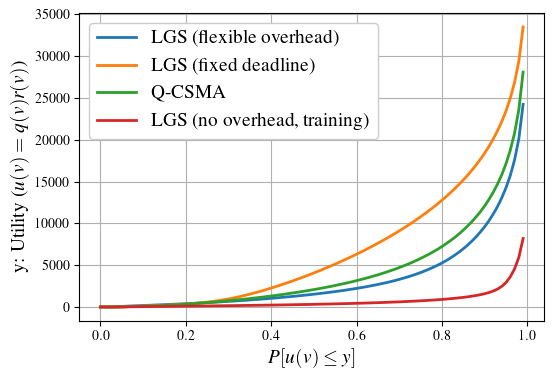

In [27]:
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4))
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)


idx=40

for experiment in qt_vals.keys():
    ax.plot(quantiles, qt_vals[experiment], label=experiment, 
                  linewidth=2.0, 
                  markersize=16,
                     )
    print('{}: {} @ {}'.format(experiment, qt_vals[experiment][idx], quantiles[idx]))
L = ax.legend(fontsize=14)
ax.grid(True)
ax.legend(labels=['LGS (flexible overhead)', 'LGS (fixed deadline)', 'Q-CSMA', 'LGS (no overhead, training)'], 
          fontsize=14)
# labels = ['Dense LGS', 'Sparse Stat', 'Sparse GCN']
# for idx in range(len(labels)):
#     L.get_texts()[idx].set_text(labels[idx])
ax.set_ylabel('y: Utility ($u(v)=q(v)r(v)$)', fontsize=14)
ax.set_xlabel('$P[u(v)\leq y]$', fontsize=14)


overhead: 1036.0 @ 0.4
deadline: 2262.0 @ 0.4
qcsma: 1316.0 @ 0.4
original: 228.0 @ 0.4


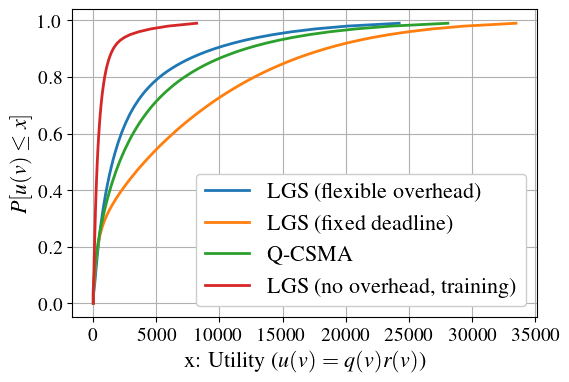

In [28]:
fig, ax = plt.subplots(1, 1, sharey=False, figsize=(6, 4))
# ax = sns.boxplot(x="N_p", y="q_avg", hue="name", data=df_tmp, palette="Set3", showmeans=True)


idx=40

for experiment in qt_vals.keys():
    ax.plot(qt_vals[experiment], quantiles, label=experiment, 
                  linewidth=2.0, 
                  markersize=16,
                     )
    print('{}: {} @ {}'.format(experiment, qt_vals[experiment][idx], quantiles[idx]))
L = ax.legend(fontsize=16)
ax.grid(True)
ax.legend(labels=['LGS (flexible overhead)', 'LGS (fixed deadline)', 'Q-CSMA', 'LGS (no overhead, training)'], 
          fontsize=16)
# labels = ['Dense LGS', 'Sparse Stat', 'Sparse GCN']
# for idx in range(len(labels)):
#     L.get_texts()[idx].set_text(labels[idx])
ax.set_xlabel('x: Utility ($u(v)=q(v)r(v)$)', fontsize=16)
ax.set_ylabel('$P[u(v)\leq x]$', fontsize=16)
fontsize = 14
for item in ([ax.title] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(fontsize)


fname= os.path.join('./output/', 'sparse_wireless_eCDF_utilities_test')
fname = fname + '.pdf'
fig.set_size_inches(6, 4.0)
# plt.tight_layout()
fig.savefig(fname,
            dpi=300,
            bbox_inches='tight',
            pad_inches=0.02,
            orientation='portrait',
            format='pdf')
fig.savefig(fname.replace('.pdf','.eps'), 
            dpi=300, #facecolor='w', edgecolor='w',
            orientation='portrait',
            pad_inches=0.05,
            bbox_inches='tight',
            format='eps')

## Read the eCDF of per-link utility from test graph set under traffic load setting

In [20]:
quantiles = np.arange(0.0, 1.0, 0.01)
quantiles = np.round(quantiles, 3)
experiments = ['overhead', 'deadline', 'qcsma']

for experiment in experiments:
    util_exp_csv_full = './wireless/sparse_schedule_exp_{}_greedy_utility_ecdf.csv'.format(experiment)
    util_exp = np.array([])
    for data_idx in [1,2,3]:
        datapath = './data/ER_Graph_Uniform_GEN2{}_test2'.format(data_idx)
        datafolder = datapath.split('/')[-1]
        output_dir = './wireless/{}_{}_SPAFooF1v7_l1_0.80'.format(datafolder, experiment)
        csvfile_names = sorted(os.listdir(output_dir))
        for csvfile in csvfile_names:
            if not 'sparse_schedule_dense_utility_by_link_graph' in csvfile:
                continue
            else:
                csvfull = os.path.join(output_dir, csvfile)
                # print('load {}'.format(csvfull))
            tmp = np.loadtxt(csvfull, delimiter=",")
            util_exp = np.append(util_exp, tmp.flatten())
    # np.savetxt(util_exp_csv_full, util_exp, delimiter=',', fmt='%1.3f')
    # print('save utility ecdf to {}'.format(util_exp_csv_full))
    qt_v = np.nanquantile(util_exp, quantiles)
    util_qt_csv_full = './wireless/sparse_schedule_exp_{}_greedy_utility_percentiles.csv'.format(experiment)
    np.savetxt(util_qt_csv_full, qt_v, delimiter=',', fmt='%1.3f')
    print('save percentile to {}'.format(util_qt_csv_full))

save utility ecdf to ./wireless/sparse_schedule_exp_overhead_greedy_utility_ecdf.csv
save utility ecdf to ./wireless/sparse_schedule_exp_deadline_greedy_utility_ecdf.csv
save utility ecdf to ./wireless/sparse_schedule_exp_qcsma_greedy_utility_ecdf.csv


In [21]:
# quantiles = np.concatenate((np.arange(0.0, 1.0, 0.1), np.array([0.85, 0.95])), axis=0)
quantiles = np.arange(0.0, 1.0, 0.01)
quantiles = np.round(quantiles, 3)

experiments = ['overhead', 'deadline', 'qcsma']
for experiment in experiments:
    util_exp_csv_full = './wireless/sparse_schedule_exp_{}_greedy_utility_ecdf.csv'.format(experiment)
    tmp = np.loadtxt(util_exp_csv_full, delimiter=",")
    qt_v = np.nanquantile(tmp, quantiles)
    util_qt_csv_full = './wireless/sparse_schedule_exp_{}_greedy_utility_percentiles.csv'.format(experiment)
    np.savetxt(util_qt_csv_full, qt_v, delimiter=',', fmt='%1.3f')
    print('save percentile to {}'.format(util_qt_csv_full))

save percentile to ./wireless/sparse_schedule_exp_overhead_greedy_utility_percentiles.csv
save percentile to ./wireless/sparse_schedule_exp_deadline_greedy_utility_percentiles.csv
save percentile to ./wireless/sparse_schedule_exp_qcsma_greedy_utility_percentiles.csv
